### Machine Learning Methods - shrec14 dataset

import libraries

In [1]:
import numpy as np
import multidim
import itertools
import os
import hdbscan
import sys
import time
import pandas as pd
import itertools
import pickle

from copy import deepcopy
from matplotlib.patches import Ellipse
from ripser import ripser
from persim import plot_diagrams
from numba import jit, njit, prange
from sklearn import mixture
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.kernel_ridge import KernelRidge

from multidim.covertree import CoverTree
from multidim.models import CDER

import matplotlib.pyplot as plt

from persim import PersImage


sys.path.append('../persistence_methods')
import ATS
from persistence_methods import kernel_features
from persistence_methods import tent_features
from persistence_methods import carlsson_coordinates
from persistence_methods import adaptive_features
from persistence_methods import landscape_features
from persistence_methods import persistence_image_features
from persistence_methods import fast_kernel_features

import data

In [2]:
Data = pd.read_csv('data/Uli_data.csv')

In [3]:
def reshapeVec(g):
    A = np.array([g.dim,g.birth,g.death])
    A = A.T
    return A

In [4]:
DgmsDF = Data.groupby(['freq', 'trial']).apply(reshapeVec)
DgmsDF = DgmsDF.reset_index()
DgmsDF = DgmsDF.rename(columns = {0:'CollectedDgm'})

In [5]:
def getDgm(A, dim = 0):
    if type(dim) != str:
        if dim == 0:
            A = A[np.where(np.logical_or(A[:,0] == dim, A[:,0] == -1))[0],1:]
            
        if dim == 1:
            A = A[np.where(np.logical_or(A[:,0] == dim, A[:,0] == -2))[0],1:]
    
    return(A)

In [6]:
DgmsDF['Dgm1'] = DgmsDF.CollectedDgm.apply(lambda x: getDgm(x, dim = 1))
DgmsDF['Dgm0'] = DgmsDF.CollectedDgm.apply(lambda x: getDgm(x, dim = 0))
DgmsDF['DgmInf'] = DgmsDF.CollectedDgm.apply(lambda x: getDgm(x, dim = 'essential'))

In [7]:
def label(index):
    if 0 <= index <= 19:
        return 'male_neutral'
    elif 20<= index <=39:
        return 'male_bodybuilder'
    elif 40<= index <=59:
        return 'male_fat'
    elif 60<= index <=79:
        return 'male_thin'
    elif 80<= index <=99:
        return 'male_average'
    elif 100<= index <=119:
        return 'female_neutral'
    elif 120<= index <=139:
        return 'female_bodybuilder'
    elif 140<= index <=159:
        return 'female_fat'
    elif 160<= index <=179:
        return 'female_thin'
    elif 180<= index <=199:
        return 'female_average'
    elif 200<= index <=219:
        return 'child_neutral'
    elif 220<= index <=239:
        return 'child_bodybuilder'
    elif 240<= index <=259:
        return 'child_fat'
    elif 260<= index <=279:
        return 'child_thin'
    elif 280<= index <=299:
        return 'child_average'
    else:
        print('What are you giving me?')

In [8]:
DgmsDF['TrainingLabel'] = DgmsDF.freq.apply(label)
DgmsDF= DgmsDF.sample(frac=1)

In [9]:
T1 = DgmsDF[DgmsDF.trial==7]
X_dgm0 = np.array(T1['Dgm0'])
X_dgm1 = np.array(T1['Dgm1'])

labels = np.array(T1['TrainingLabel'])
print(type(labels))
#labels = [d.split('_',1)[0] for d in labels]
labels = pd.DataFrame(labels)
label_names = labels.copy()

label_unique = pd.DataFrame(labels)
label_unique = label_unique[0].unique()

i=0
for l in label_unique:
    labels[labels == l]=i
    i += 1

labels = labels[0].tolist()
label_names = label_names[0].tolist()

<class 'numpy.ndarray'>


In [19]:
Data_full = np.vstack([X_dgm0, X_dgm1])

In [22]:
Data_full = np.transpose(Data_full)

In [24]:
n,p = Data_full.shape
np_data = np.array(Data_full)
total_birth_death_pairs = 0
max_birth_death_pairs = 0
min_birth_death_pairs = 250000
for i in range(0,n):
    for j in range(0,p):
        total_birth_death_pairs += len(np_data[i,j])
        max_birth_death_pairs = max(max_birth_death_pairs,len(np_data[i,j]))
        min_birth_death_pairs = min(min_birth_death_pairs,len(np_data[i,j]))
print(total_birth_death_pairs/(n*(p)))
print(min_birth_death_pairs)
print(max_birth_death_pairs)

14.116666666666667
1
29


#### Hold out for parameter tuning

In [10]:
n = len(labels)
index = np.arange(0,n)
tuning_index, training_index = train_test_split(index, test_size = .7, random_state=12, stratify = labels)

In [11]:
X_dgm0_tuning = X_dgm0[tuning_index]
X_dgm1_tuning = X_dgm1[tuning_index]
labels_tuning = np.array(labels)[tuning_index]

In [87]:
len(training_index)

210

creating training index

In [12]:
X_dgm0_train, X_dgm0_test, X_dgm1_train, X_dgm1_test, y_train, y_test = train_test_split(X_dgm0_tuning, X_dgm1_tuning, labels_tuning, test_size = .2, random_state=12, stratify = labels_tuning)

### Plot Data

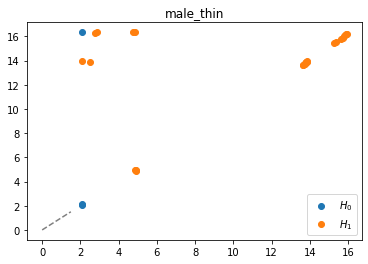

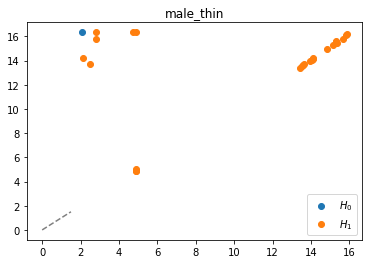

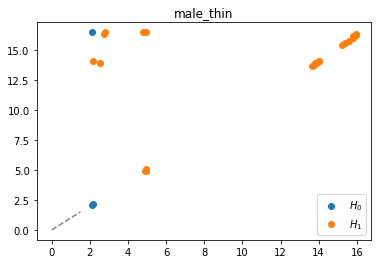

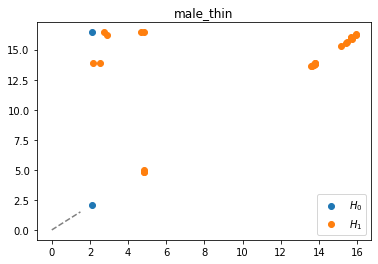

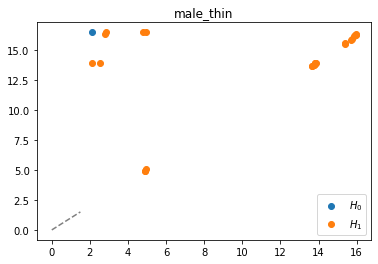

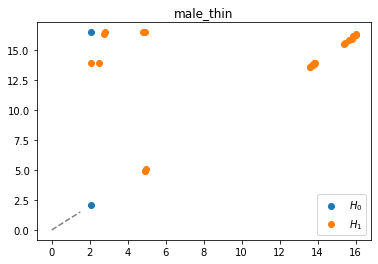

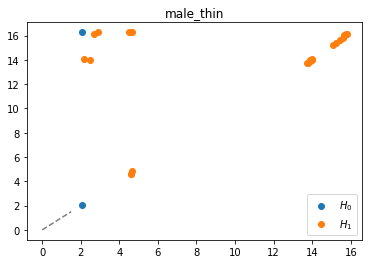

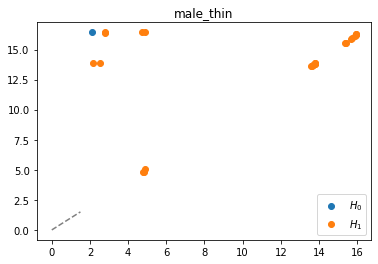

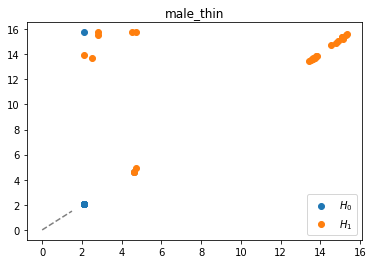

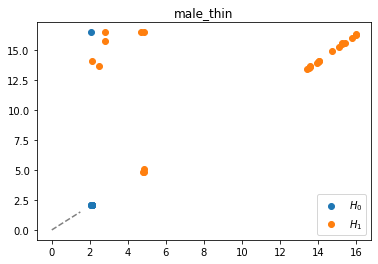

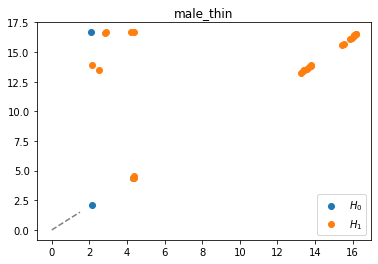

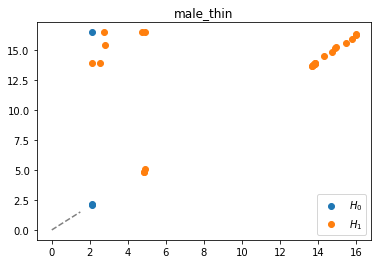

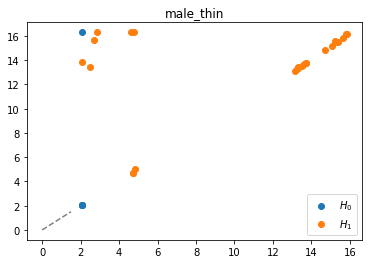

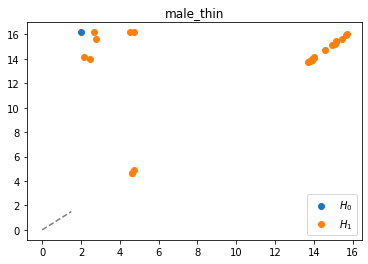

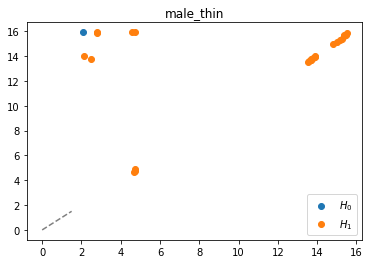

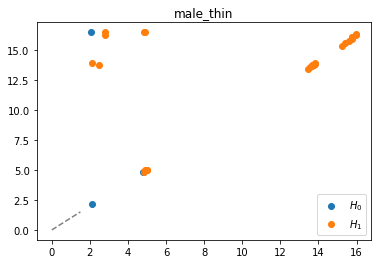

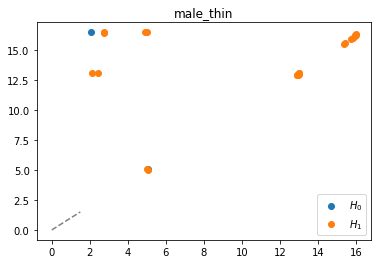

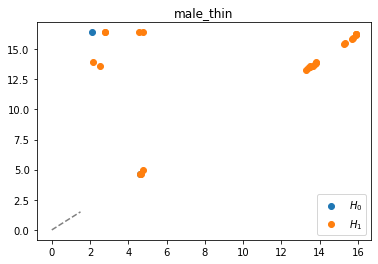

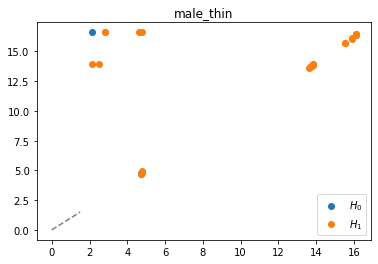

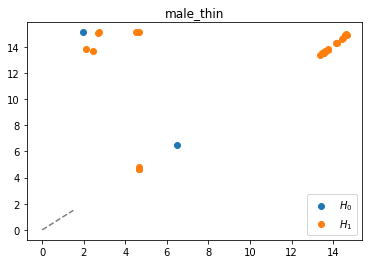

In [13]:
name = 'male_thin'
named_X_dgm0 = []
named_X_dgm1 = []
for i in range(0, len(labels)):
    if label_names[i]==name:
        named_X_dgm0.append(X_dgm0[i])
        named_X_dgm1.append(X_dgm1[i])
    else:
        0==0
        
for i in range(0,len(named_X_dgm0)):
    dgm0 = named_X_dgm0[i]
    dgm1 = named_X_dgm1[i]
    
    plt.scatter(dgm0[:,0], dgm0[:,1], label=r'$H_0$')
    plt.scatter(dgm1[:,0], dgm1[:,1], label=r'$H_1$')
    plt.plot(np.arange(0,1.6,0.1), np.arange(0,1.6,0.1), '--', c='gray')
    plt.legend(loc='lower right')
    plt.title(name)
    plt.show() 

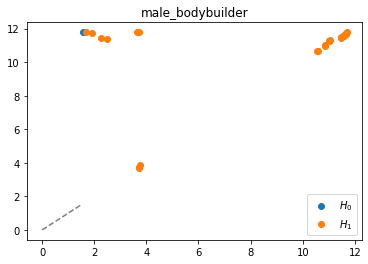

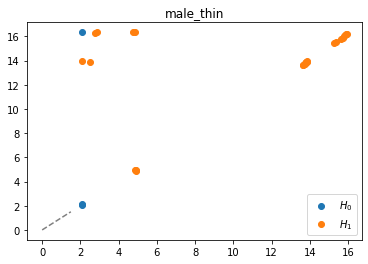

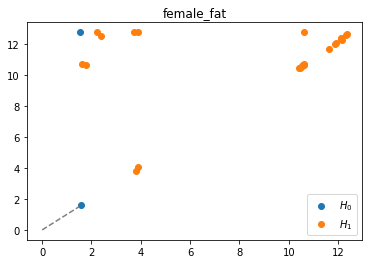

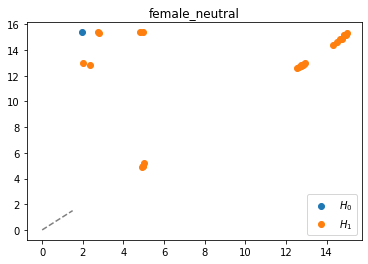

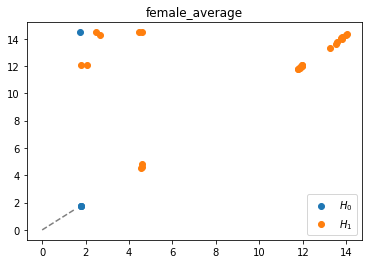

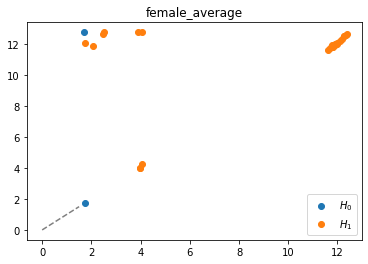

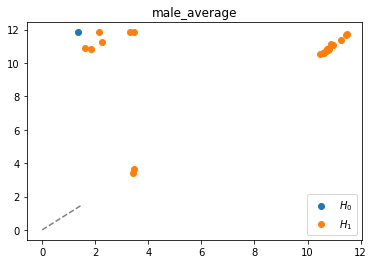

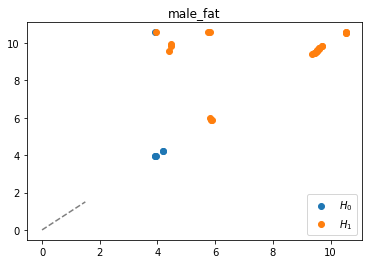

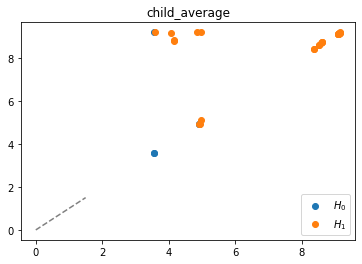

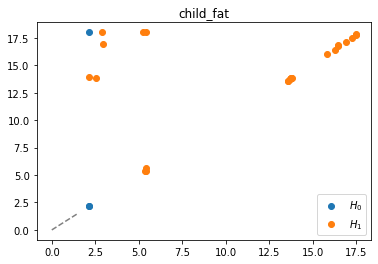

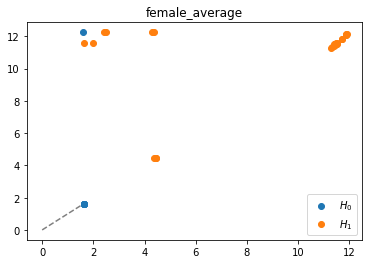

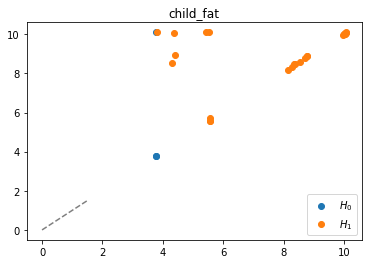

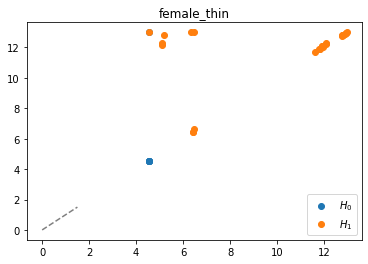

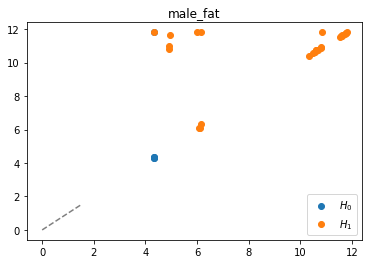

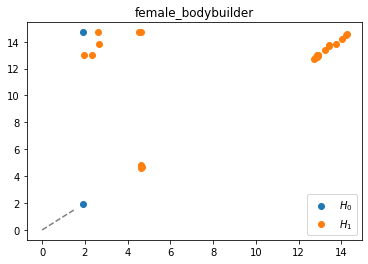

In [14]:
for i in range(15):
    dgm0 = X_dgm0[labels.index(i)]
    dgm1 = X_dgm1[labels.index(i)]
    
    plt.scatter(dgm0[:,0], dgm0[:,1], label=r'$H_0$')
    plt.scatter(dgm1[:,0], dgm1[:,1], label=r'$H_1$')
    plt.plot(np.arange(0,1.6,0.1), np.arange(0,1.6,0.1), '--', c='gray')
    plt.legend(loc='lower right')
    plt.title(label_names[i])
    plt.show()

### Generic 0-dim homology

In [15]:
# -----------------------------------------------------------------------------
# ------------------------------ GMM ------------------------------------------
# -----------------------------------------------------------------------------
d=5
print('Begin GMM...')
t0 = time.time()
X_train_temp = np.vstack(X_dgm0_train)

X_train_temp = X_train_temp[:,1]

X_train_temp = X_train_temp.reshape((-1,1))

gmm_f_train=[]
for i in range(len(X_dgm0_train)):
    gmm_f_train.append(y_train[i]*np.ones(len(X_dgm0_train[i])))
gmm_f_train = np.concatenate(gmm_f_train)

gmm = mixture.BayesianGaussianMixture(n_components=d, covariance_type='full', max_iter=int(10e4)).fit(X_train_temp, gmm_f_train)

ellipses = []
for i in range(len(gmm.means_)):
    L, v = np.linalg.eig(gmm.covariances_[i])
    temp = {'mean':gmm.means_[i], 'std':np.sqrt(L), 'rotation':v.transpose(), 'radius':max(np.sqrt(L)), 'entropy':gmm.weights_[i]}
    ellipses.append(temp)
t1 = time.time()
print('Finish GMM. Time: {}'.format(t1-t0))

# -----------------------------------------------------------------------------
# ------------------------------ GMM features ---------------------------------
# -----------------------------------------------------------------------------
t0 = time.time()

X_train_temp = [dgm[:,1] for dgm in X_dgm0_train]
X_train_features_0 = ATS.get_all_features(X_train_temp, ellipses, ATS.f_gaussian)

X_test_temp = [dgm[:,1] for dgm in X_dgm0_test]
X_test_features_0 = ATS.get_all_features(X_test_temp, ellipses, ATS.f_gaussian)

t1 = time.time()
print('Computing features from H_0 took (seconds):{}'.format(t1-t0))

Begin GMM...
Finish GMM. Time: 0.045305728912353516
Computing features from H_0 took (seconds):0.025456905364990234


### Tent functions

#### Parameter Tuning

In [69]:
d = [3,4,5,6,7,8,9,10,11,12,13,14,15]
p = [.5,.6,.7,.8,.9,1,1.1,1.2]
train_accuracy = []
test_accuracy = []
d_model = []
p_model = []
c_model = []
model_type = []
for i in d:
    for j in p:
        X_train_features_1_tent, X_test_features_1_tent = tent_features(X_dgm1_train, X_dgm1_test, d = i, padding = j)
        X_train_features_0_tent, X_test_features_0_tent = tent_features(X_dgm0_train, X_dgm0_test, d = i, padding = j)
        X_train_features = np.column_stack((X_train_features_0_tent, X_train_features_1_tent))
        X_test_features = np.column_stack((X_test_features_0_tent, X_test_features_1_tent))
        ridge_model = RidgeClassifier().fit(X_train_features, y_train)
        train_accuracy.append(ridge_model.score(X_train_features, y_train))
        test_accuracy.append(ridge_model.score(X_test_features, y_test))
        d_model.append(i)
        p_model.append(j)
        model_type.append('Ridge Regression')
        c_model.append(0)
        c = [1,2,3,5,10]
        for k in c:
            clf = SVC(kernel='rbf', C=k).fit(X_train_features, y_train)
            train_accuracy.append(clf.score(X_train_features, y_train))
            test_accuracy.append(clf.score(X_test_features, y_test))
            d_model.append(i)
            p_model.append(j)
            model_type.append('SVC')
            c_model.append(k)

Computing features took (seconds):0.011407136917114258
Computing features took (seconds):0.009769201278686523
Computing features took (seconds):0.008679866790771484
Computing features took (seconds):0.008993864059448242
Computing features took (seconds):0.0076258182525634766
Computing features took (seconds):0.008068084716796875
Computing features took (seconds):0.007534027099609375
Computing features took (seconds):0.0077250003814697266
Computing features took (seconds):0.006685972213745117
Computing features took (seconds):0.008503198623657227
Computing features took (seconds):0.00900411605834961
Computing features took (seconds):0.006579875946044922
Computing features took (seconds):0.006412982940673828
Computing features took (seconds):0.005568981170654297
Computing features took (seconds):0.0063512325286865234
Computing features took (seconds):0.007244110107421875
Computing features took (seconds):0.0174100399017334
Computing features took (seconds):0.017322063446044922
Computing 

Computing features took (seconds):0.21450114250183105
Computing features took (seconds):0.1836857795715332
Computing features took (seconds):0.20975828170776367
Computing features took (seconds):0.16565823554992676
Computing features took (seconds):0.21643900871276855
Computing features took (seconds):0.17592883110046387
Computing features took (seconds):0.2231919765472412
Computing features took (seconds):0.18314909934997559
Computing features took (seconds):0.2553279399871826
Computing features took (seconds):0.2235250473022461
Computing features took (seconds):0.3043971061706543
Computing features took (seconds):0.2230510711669922
Computing features took (seconds):0.30951595306396484
Computing features took (seconds):0.20188498497009277
Computing features took (seconds):0.3225820064544678
Computing features took (seconds):0.2373347282409668
Computing features took (seconds):0.2960169315338135
Computing features took (seconds):0.2360210418701172
Computing features took (seconds):0.28

In [64]:
tent_results = pd.DataFrame()
tent_results['Training Accuracy'] = train_accuracy
tent_results['Test Accuracy'] = test_accuracy
tent_results['d'] = d_model
tent_results['p'] = p_model
tent_results['c'] = c_model
tent_results['Model Type'] = model_type

In [66]:
tent_sorted = tent_results.sort_values(by=['Test Accuracy', 'Training Accuracy'],ascending=False)
tent_sorted[50:100]

,Training Accuracy,Test Accuracy,d,p,c,Model Type
345,0.958333,0.888889,10,0.6,3,SVC
350,0.958333,0.888889,10,0.7,2,SVC
351,0.958333,0.888889,10,0.7,3,SVC
357,0.958333,0.888889,10,0.8,3,SVC
222,0.944444,0.888889,7,1.0,0,Ridge Regression
288,0.944444,0.888889,9,0.5,0,Ridge Regression
338,0.944444,0.888889,10,0.5,2,SVC
469,0.944444,0.888889,12,1.1,1,SVC
475,0.944444,0.888889,12,1.2,1,SVC
29,0.902778,0.888889,3,0.9,10,SVC


In [17]:
X_train_features_1_tent, X_test_features_1_tent = tent_features(X_dgm1_train, X_dgm1_test, d = 10, padding = .6)

Computing features took (seconds):0.15649700164794922


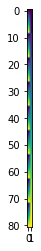

In [39]:
### Plot of Tent function

### Adaptive features GMM

In [74]:
d = [1,2,3,4, 5,10,15,20,25,30,35,40,45,50]
train_accuracy = []
test_accuracy = []
d_model = []
c_model = []
model_type = []
for i in d:
    X_train_features_1_gmm, X_test_features_1_gmm = adaptive_features(X_dgm1_train, X_dgm1_test, "gmm", y_train, d=i)
    X_train_features_0_gmm, X_test_features_0_gmm = adaptive_features(X_dgm0_train, X_dgm0_test, "gmm", y_train, d=i)
    X_train_features = np.column_stack((X_train_features_0_gmm, X_train_features_1_gmm))
    X_test_features = np.column_stack((X_test_features_0_gmm, X_test_features_1_gmm))
    ridge_model = RidgeClassifier().fit(X_train_features, y_train)
    train_accuracy.append(ridge_model.score(X_train_features, y_train))
    test_accuracy.append(ridge_model.score(X_test_features, y_test))
    d_model.append(i)
    model_type.append('Ridge Regression')
    c_model.append(0)
    for j in [1,2,3,5,10]:
        clf = SVC(kernel='rbf', C=j).fit(X_train_features, y_train)
        train_accuracy.append(clf.score(X_train_features, y_train))
        test_accuracy.append(clf.score(X_test_features, y_test))
        d_model.append(i)
        model_type.append('SVC')
        c_model.append(j)

Begin GMM...
Computing gmm features took (seconds):0.016045808792114258
Begin GMM...
Computing gmm features took (seconds):0.010550975799560547
Begin GMM...
Computing gmm features took (seconds):0.019457101821899414
Begin GMM...
Computing gmm features took (seconds):0.010473012924194336
Begin GMM...
Computing gmm features took (seconds):0.034542083740234375
Begin GMM...
Computing gmm features took (seconds):0.01332712173461914
Begin GMM...
Computing gmm features took (seconds):0.045603036880493164
Begin GMM...
Computing gmm features took (seconds):0.02039027214050293
Begin GMM...
Computing gmm features took (seconds):0.059159040451049805
Begin GMM...
Computing gmm features took (seconds):0.03895115852355957
Begin GMM...
Computing gmm features took (seconds):0.15947508811950684
Begin GMM...
Computing gmm features took (seconds):0.06405091285705566
Begin GMM...
Computing gmm features took (seconds):0.31168413162231445
Begin GMM...
Computing gmm features took (seconds):0.09980297088623047

In [75]:
gmm_results = pd.DataFrame()
gmm_results['Training Accuracy'] = train_accuracy
gmm_results['Test Accuracy'] = test_accuracy
gmm_results['d'] = d_model
gmm_results['c'] = c_model
gmm_results['Model Type'] = model_type

gmm_sorted = gmm_results.sort_values(by=['Test Accuracy', 'Training Accuracy'],ascending=False)
gmm_sorted

,Training Accuracy,Test Accuracy,d,c,Model Type
30,0.930556,0.611111,10,0,Ridge Regression
54,0.930556,0.611111,30,0,Ridge Regression
66,0.930556,0.611111,40,0,Ridge Regression
29,0.861111,0.611111,5,10,SVC
17,0.833333,0.611111,3,10,SVC
...,...,...,...,...,...
3,0.430556,0.277778,1,3,SVC
2,0.402778,0.277778,1,2,SVC
1,0.375000,0.277778,1,1,SVC
6,0.402778,0.222222,2,0,Ridge Regression


### CDER

In [76]:
X_train_features_1_cder, X_test_features_1_cder = adaptive_features(X_dgm1_train, X_dgm1_test, "cder", y_train)
X_train_features_0_cder, X_test_features_0_cder = adaptive_features(X_dgm0_train, X_dgm0_test, "cder", y_train)
X_train_features = np.column_stack((X_train_features_0_cder, X_train_features_1_cder))
X_test_features = np.column_stack((X_test_features_0_cder, X_test_features_1_cder))

train_accuracy = []
test_accuracy = []
c_model = []
model_type = []

ridge_model = RidgeClassifier().fit(X_train_features, y_train)

train_accuracy.append(ridge_model.score(X_train_features, y_train))
test_accuracy.append(ridge_model.score(X_test_features, y_test))
model_type.append('Ridge Regression')
c_model.append(0)

c = [1,2,3,5,10,20]
for i in c:
    clf = SVC(kernel='rbf', C=i).fit(X_train_features, y_train)
    train_accuracy.append(clf.score(X_train_features, y_train))
    test_accuracy.append(clf.score(X_test_features, y_test))
    model_type.append('SVC')
    c_model.append(j)

Begin CDER...


Computing features from H_1 took (seconds):1.758563756942749
Begin CDER...
Computing features from H_1 took (seconds):0.21559882164001465


In [77]:
cder_results = pd.DataFrame()
cder_results['Training Accuracy'] = train_accuracy
cder_results['Test Accuracy'] = test_accuracy
cder_results['c'] = c_model
cder_results['Model Type'] = model_type

cder_sorted = cder_results.sort_values(by=['Test Accuracy', 'Training Accuracy'],ascending=False)
cder_sorted

,Training Accuracy,Test Accuracy,c,Model Type
1,0.986111,0.888889,10,SVC
0,1.000000,0.833333,0,Ridge Regression
2,1.000000,0.833333,10,SVC
3,1.000000,0.833333,10,SVC
4,1.000000,0.833333,10,SVC
5,1.000000,0.833333,10,SVC
6,1.000000,0.833333,10,SVC


In [81]:
y_train

array([12, 13,  5,  4, 10, 12,  8,  6, 14, 12,  9,  1, 14, 11, 13,  2,  8,
       14, 12,  2,  3, 13,  0, 14,  3, 10,  8,  2,  4,  9, 10, 13,  5,  1,
        3,  2,  2,  7,  6,  1,  7, 13, 10,  0,  5,  5,  1,  8,  1,  4,  9,
        5,  0,  6,  9,  7, 11, 11, 11,  4,  9,  0,  3,  4,  7,  0, 12, 10,
        7,  3,  8,  6])

In [85]:
def getRGBfromI(RGBint):
    blue =  RGBint & 255
    green = (RGBint >> 8) & 255
    red =   (RGBint >> 16) & 255
    return red, green, blue
y_train_cder = []
for i in range(0, len(y_train)):
    color = getRGBfromI(y_train[i])
    y_train_cder.append(color)
    


pc_train = multidim.PointCloud.from_multisample_multilabel(X_dgm0_train, y_train_cder)
ct_train = CoverTree(pc_train)

cder = CDER(parsimonious=True)

cder.fit(ct_train)

cder_result = cder.gaussians

ellipses = []
for c in cder_result:
    temp = {key:c[key] for key in ['mean', 'std', 'rotation', 'radius', 'entropy']}
    temp['std'] = 3*temp['std']
    ellipses.append(temp)

KeyError: "None of [Int64Index([0, 0, 0], dtype='int64')] are in the [index]"

ValueError: Invalid RGBA argument: 0.5384615384615384

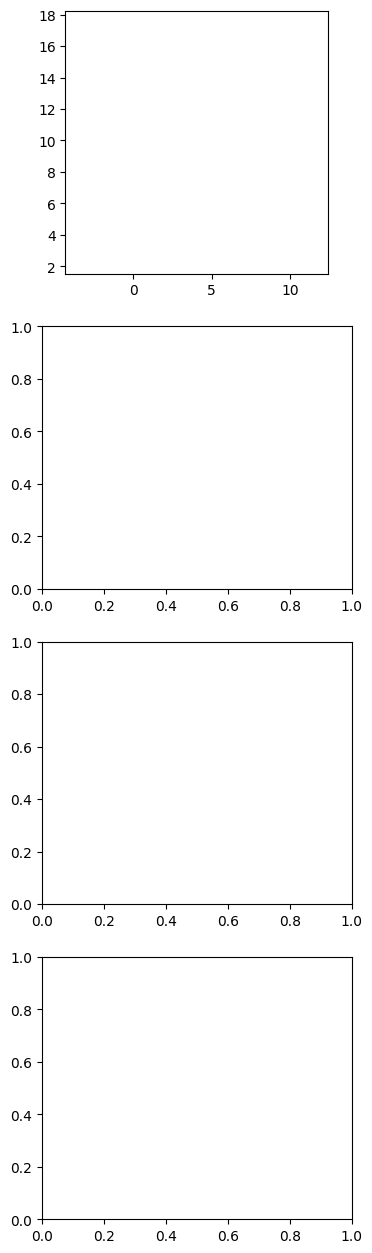

In [84]:
fig,ax = plt.subplots(4, figsize=(4,16), dpi=100)
cder.plot(ax[0], style="gaussians")
cder.plot(ax[1], style="covertree")
cder.plot(ax[2], style="hulls")
cder.plot(ax[3], style="heatmap")
for i in range(4):
    ax[i].set_aspect('equal')
    ax[i].set_xlim(-7,7)
    ax[i].set_ylim(-7,7)
plt.tight_layout()
plt.show()


In [59]:
y_train

array([12, 13,  5,  4, 10, 12,  8,  6, 14, 12,  9,  1, 14, 11, 13,  2,  8,
       14, 12,  2,  3, 13,  0, 14,  3, 10,  8,  2,  4,  9, 10, 13,  5,  1,
        3,  2,  2,  7,  6,  1,  7, 13, 10,  0,  5,  5,  1,  8,  1,  4,  9,
        5,  0,  6,  9,  7, 11, 11, 11,  4,  9,  0,  3,  4,  7,  0, 12, 10,
        7,  3,  8,  6])

[144 144 144 144 144 144]
[156 156 156 156 156 156 156 156]
[60 60]
[48]
[120 120]
[144 144 144 144 144]
[96 96 96 96]
[72 72]
[168]
[144 144 144 144 144]
[108 108 108]
[12 12]
[168 168]
[132 132 132]
[156 156 156]
[24 24]
[96 96 96]
[168 168]
[144 144 144]
[24 24 24]
[36 36 36 36 36 36]
[156 156 156 156 156]
[0 0 0]
[168 168 168]
[36]
[120 120 120]
[96 96 96]
[24]
[48 48 48]
[108]
[120 120]
[156 156 156 156]
[60 60 60 60 60]
[12 12 12]
[36]
[24 24 24 24]
[24 24 24]
[84 84 84]
[72 72]
[12 12]
[84 84 84]
[156 156 156 156 156]
[120 120]
[0 0]
[60]
[60]
[12 12 12]
[96 96 96]
[12 12 12]
[48 48]
[108 108 108 108 108]
[60 60]
[0 0]
[72 72 72 72]
[108 108]
[84 84]
[132 132 132]
[132 132]
[132 132]
[48 48 48 48 48 48 48]
[108 108]
[0 0 0]
[36]
[48]
[84 84 84]
[0 0]
[144 144 144]
[120 120]
[84 84 84 84]
[36 36 36 36 36 36 36 36]
[96 96 96]
[72]


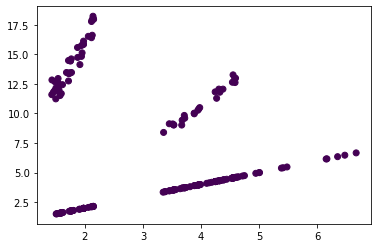

In [70]:
#plt.scatter(X_dgm0_train[:,0], X_dgm0_train[:,1])
np.array(X_dgm0_train[0]).shape
fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(0, 72):
    color = np.repeat(y_train[i], len(X_dgm0_train[i]))*12
    print(color)
    ax1.scatter(X_dgm0_train[i][:,0],X_dgm0_train[i][:,1], c = color)

### HDB Scan

In [17]:
X_train_features_1_hdb, X_test_features_1_hdb = adaptive_features(X_dgm1_train, X_dgm1_test, "hdb", y_train)
X_train_features_0_hdb, X_test_features_0_hdb = adaptive_features(X_dgm0_train, X_dgm0_test, "hdb", y_train)
X_train_features = np.column_stack((X_train_features_0_hdb, X_train_features_1_hdb))
X_test_features = np.column_stack((X_test_features_0_hdb, X_test_features_1_hdb))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)
print("Train Accuracy: ", ridge_model.score(X_train_features, y_train), "Test Accuracy: ", ridge_model.score(X_test_features, y_test))
c = [1,2,3,5,10,20]
for i in c:
    clf = SVC(kernel='rbf', C=i).fit(X_train_features, y_train)
    print('C: ', i, "Train Accuracy: ", clf.score(X_train_features, y_train), "Test Accuracy: ", clf.score(X_test_features, y_test))

Begin HDBSCAN...
Computing hdbscan features took (seconds):2.672384023666382
Begin HDBSCAN...
Computing hdbscan features took (seconds):0.3215632438659668
Train Accuracy:  1.0 Test Accuracy:  0.7
C:  1 Train Accuracy:  0.9791666666666666 Test Accuracy:  0.6833333333333333
C:  2 Train Accuracy:  1.0 Test Accuracy:  0.6833333333333333
C:  3 Train Accuracy:  1.0 Test Accuracy:  0.7166666666666667
C:  5 Train Accuracy:  1.0 Test Accuracy:  0.7
C:  10 Train Accuracy:  1.0 Test Accuracy:  0.7
C:  20 Train Accuracy:  1.0 Test Accuracy:  0.7


### Persistence Images

In [78]:
pixels = [[15,15],[20,20],[25,25],[30,30],[35,35],[40,40]]
spread = [.05,.5,1]

train_accuracy = []
test_accuracy = []
p_model = []
s_model = []
c_model = []
model_type = []

for p in pixels:
    for s in spread:
        X_train_features_1_imgs, X_test_features_1_imgs = persistence_image_features(X_dgm1_train, X_dgm1_test, pixels=p, spread=s)
        X_train_features_0_imgs, X_test_features_0_imgs = persistence_image_features(X_dgm0_train, X_dgm0_test, pixels = p, spread=s)
        X_train_features = np.column_stack((X_train_features_1_imgs,X_train_features_0_imgs))
        X_test_features = np.column_stack((X_test_features_1_imgs,X_test_features_0_imgs))
        ridge_model = RidgeClassifier().fit(X_train_features, y_train)
        train_accuracy.append(ridge_model.score(X_train_features, y_train))
        test_accuracy.append(ridge_model.score(X_test_features, y_test))
        p_model.append(p)
        s_model.append(s)
        model_type.append('Ridge Regression')
        c_model.append(0)
        c = [1,2,3,5,10,20]
        for i in c:
            clf = SVC(kernel='rbf', C=i).fit(X_train_features, y_train)
            train_accuracy.append(clf.score(X_train_features, y_train))
            test_accuracy.append(clf.score(X_test_features, y_test))
            p_model.append(p)
            s_model.append(s)
            model_type.append('SVC')
            c_model.append(i)

PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.8062877655029297
PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=0.05, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.13723397254943848
PersImage(pixels=[15, 15], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.8309428691864014
PersImage(pixels=[15, 15], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.14452886581420898
PersImage(pixels=[15, 15], spread=1, specs=None, kernel_type="gaus

PersImage(pixels=[40, 40], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  0.14379501342773438


In [82]:
pi_results = pd.DataFrame()
pi_results['Training Accuracy'] = train_accuracy
pi_results['Test Accuracy'] = test_accuracy
pi_results['p'] = p_model
pi_results['s'] = s_model
pi_results['c'] = c_model
pi_results['Model Type'] = model_type

pi_sorted = pi_results.sort_values(by=['Test Accuracy', 'Training Accuracy'],ascending=False)
pi_sorted[10:60]

,Training Accuracy,Test Accuracy,p,s,c,Model Type
64,0.986111,0.888889,"[30, 30]",0.05,1,SVC
65,0.986111,0.888889,"[30, 30]",0.05,2,SVC
23,0.972222,0.888889,"[20, 20]",0.05,2,SVC
28,0.972222,0.888889,"[20, 20]",0.50,0,Ridge Regression
22,0.958333,0.888889,"[20, 20]",0.05,1,SVC
33,1.000000,0.833333,"[20, 20]",0.50,10,SVC
34,1.000000,0.833333,"[20, 20]",0.50,20,SVC
42,1.000000,0.833333,"[25, 25]",0.05,0,Ridge Regression
63,1.000000,0.833333,"[30, 30]",0.05,0,Ridge Regression
84,1.000000,0.833333,"[35, 35]",0.05,0,Ridge Regression


### Landscapes

In [84]:
n = [2,3,4,5,6,7,8,9,10]
r = [50,100,200,300,400,500]

train_accuracy = []
test_accuracy = []
n_model = []
r_model = []
c_model = []
model_type = []

for i in n:
    for j in r:
        X_train_features_1_landscapes, X_test_features_1_landscapes = landscape_features(X_dgm1_train, X_dgm1_test, num_landscapes=i, resolution=j)
        X_train_features_0_landscapes, X_test_features_0_landscapes = landscape_features(X_dgm0_train, X_dgm0_test, num_landscapes=i, resolution=j)
        X_train_features = np.column_stack((X_train_features_0_landscapes, X_train_features_1_landscapes))
        X_test_features = np.column_stack((X_test_features_0_landscapes, X_test_features_1_landscapes))
        ridge_model = RidgeClassifier().fit(X_train_features, y_train)
        train_accuracy.append(ridge_model.score(X_train_features, y_train))
        test_accuracy.append(ridge_model.score(X_test_features, y_test))
        n_model.append(i)
        r_model.append(j)
        model_type.append('Ridge Regression')
        c_model.append(0)
        c = [1,2,3,5,10,20]
        for k in c:
            clf = SVC(kernel='rbf', C=k).fit(X_train_features, y_train)
            train_accuracy.append(clf.score(X_train_features, y_train))
            test_accuracy.append(clf.score(X_test_features, y_test))
            n_model.append(i)
            r_model.append(j)
            model_type.append('SVC')
            c_model.append(k)

Total Time:  0.16113996505737305
Total Time:  0.023952960968017578
Total Time:  0.15532612800598145
Total Time:  0.02568984031677246
Total Time:  0.20508480072021484
Total Time:  0.04036903381347656
Total Time:  0.18820881843566895
Total Time:  0.04068422317504883
Total Time:  0.19919705390930176
Total Time:  0.05400800704956055
Total Time:  0.20667386054992676
Total Time:  0.06392598152160645
Total Time:  0.16447019577026367
Total Time:  0.02314591407775879
Total Time:  0.17179083824157715
Total Time:  0.030447959899902344
Total Time:  0.19631004333496094
Total Time:  0.03770899772644043
Total Time:  0.2088940143585205
Total Time:  0.048787832260131836
Total Time:  0.20018720626831055
Total Time:  0.046835899353027344
Total Time:  0.22091913223266602
Total Time:  0.05243802070617676
Total Time:  0.17038488388061523
Total Time:  0.02767777442932129
Total Time:  0.19812393188476562
Total Time:  0.031160831451416016
Total Time:  0.17958712577819824
Total Time:  0.03755807876586914
Total 

In [87]:
landscape_results = pd.DataFrame()
landscape_results['Training Accuracy'] = train_accuracy
landscape_results['Test Accuracy'] = test_accuracy
landscape_results['n'] = n_model
landscape_results['r'] = r_model
landscape_results['c'] = c_model
landscape_results['Model Type'] = model_type

landscape_sorted = landscape_results.sort_values(by=['Test Accuracy', 'Training Accuracy'],ascending=False)
landscape_sorted[10:60]

,Training Accuracy,Test Accuracy,n,r,c,Model Type
14,1.000000,0.888889,2,200,0,Ridge Regression
21,1.000000,0.888889,2,300,0,Ridge Regression
28,1.000000,0.888889,2,400,0,Ridge Regression
35,1.000000,0.888889,2,500,0,Ridge Regression
56,1.000000,0.888889,3,200,0,Ridge Regression
63,1.000000,0.888889,3,300,0,Ridge Regression
70,1.000000,0.888889,3,400,0,Ridge Regression
77,1.000000,0.888889,3,500,0,Ridge Regression
112,1.000000,0.888889,4,400,0,Ridge Regression
119,1.000000,0.888889,4,500,0,Ridge Regression


### Kernel

In [88]:
sigma = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]
for s in sigma:
    X_train_features_1_kernel, X_test_features_1_kernel = fast_kernel_features(X_dgm1_train, X_dgm1_test, s)
    svc_model = NuSVC(kernel='precomputed')
    svc_model.fit(X_train_features_1_kernel, y_train)
    print("Sigma: ", s, "Train Accuracy: ", svc_model.score(X_train_features_1_kernel, y_train), "Test Accuracy: ", svc_model.score(X_test_features_1_kernel, y_test))
    

Total Time:  0.9129951000213623
Sigma:  0.05 Train Accuracy:  0.9305555555555556 Test Accuracy:  0.8333333333333334
Total Time:  0.930837869644165
Sigma:  0.1 Train Accuracy:  0.9444444444444444 Test Accuracy:  0.8888888888888888
Total Time:  0.8935511112213135
Sigma:  0.15 Train Accuracy:  0.9444444444444444 Test Accuracy:  0.8888888888888888
Total Time:  0.9454550743103027
Sigma:  0.2 Train Accuracy:  0.9444444444444444 Test Accuracy:  0.8888888888888888
Total Time:  0.9008986949920654
Sigma:  0.25 Train Accuracy:  0.9444444444444444 Test Accuracy:  0.8888888888888888
Total Time:  0.9391539096832275
Sigma:  0.3 Train Accuracy:  0.9444444444444444 Test Accuracy:  0.8888888888888888
Total Time:  0.9842078685760498
Sigma:  0.35 Train Accuracy:  0.9444444444444444 Test Accuracy:  0.8888888888888888
Total Time:  1.0045530796051025
Sigma:  0.4 Train Accuracy:  0.9444444444444444 Test Accuracy:  0.8888888888888888
Total Time:  0.9548401832580566
Sigma:  0.45 Train Accuracy:  0.9444444444444

In [89]:
sigma = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]
for s in sigma:
    X_train_features_0_kernel, X_test_features_0_kernel = fast_kernel_features(X_dgm0_train, X_dgm0_test, s)
    svc_model = NuSVC(kernel='precomputed')
    svc_model.fit(X_train_features_0_kernel, y_train)
    print("Sigma: ", s, "Train Accuracy: ", svc_model.score(X_train_features_0_kernel, y_train), "Test Accuracy: ", svc_model.score(X_test_features_0_kernel, y_test))
    

Total Time:  0.4961259365081787
Sigma:  0.05 Train Accuracy:  0.9027777777777778 Test Accuracy:  0.8333333333333334
Total Time:  0.457291841506958
Sigma:  0.1 Train Accuracy:  0.9027777777777778 Test Accuracy:  0.7777777777777778
Total Time:  0.4498300552368164
Sigma:  0.15 Train Accuracy:  0.9027777777777778 Test Accuracy:  0.7777777777777778
Total Time:  0.4475228786468506
Sigma:  0.2 Train Accuracy:  0.9027777777777778 Test Accuracy:  0.7777777777777778
Total Time:  0.48485302925109863
Sigma:  0.25 Train Accuracy:  0.9027777777777778 Test Accuracy:  0.7777777777777778
Total Time:  0.5068397521972656
Sigma:  0.3 Train Accuracy:  0.9027777777777778 Test Accuracy:  0.7777777777777778
Total Time:  0.4867589473724365
Sigma:  0.35 Train Accuracy:  0.9027777777777778 Test Accuracy:  0.7777777777777778
Total Time:  0.4717519283294678
Sigma:  0.4 Train Accuracy:  0.9027777777777778 Test Accuracy:  0.7777777777777778
Total Time:  0.46832704544067383
Sigma:  0.45 Train Accuracy:  0.90277777777

### Carlson Coordinates

In [91]:
X_train_features1_cc1, X_train_features1_cc2, X_train_features1_cc3, X_train_features1_cc4, X_test_features1_cc1, X_test_features1_cc2, X_test_features1_cc3, X_test_features1_cc4 = carlsson_coordinates(X_dgm1_train, X_dgm1_test)
X_train_features0_cc1, X_train_features0_cc2, X_train_features0_cc3, X_train_features0_cc4, X_test_features0_cc1, X_test_features0_cc2, X_test_features0_cc3, X_test_features0_cc4 = carlsson_coordinates(X_dgm0_train, X_dgm0_test)

X_train_features = np.column_stack((X_train_features1_cc1, X_train_features1_cc2, X_train_features1_cc3, X_train_features1_cc4,
                                   X_train_features0_cc1, X_train_features0_cc2, X_train_features0_cc3, X_train_features0_cc4))

X_test_features = np.column_stack((X_test_features1_cc1,X_test_features1_cc2, X_test_features1_cc3,X_test_features1_cc4,
                                  X_test_features0_cc1,X_test_features0_cc2, X_test_features0_cc3,X_test_features0_cc4))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(ridge_model.score(X_train_features, y_train))
print(ridge_model.score(X_test_features, y_test))

c = [1,2,3,5,10,20,50]
for i in c:
    clf = SVC(kernel='rbf', C=i).fit(X_train_features, y_train)
    print('C: ', i, "Train Accuracy: ", clf.score(X_train_features, y_train), "Test Accuracy: ", clf.score(X_test_features, y_test))

18.046
Total Time:  0.005366086959838867
18.046
Total Time:  0.0033512115478515625
Train/test classification accuracy with persistence functions
0.7777777777777778
0.7222222222222222
C:  1 Train Accuracy:  0.7361111111111112 Test Accuracy:  0.5555555555555556
C:  2 Train Accuracy:  0.7361111111111112 Test Accuracy:  0.5555555555555556
C:  3 Train Accuracy:  0.7916666666666666 Test Accuracy:  0.5555555555555556
C:  5 Train Accuracy:  0.8055555555555556 Test Accuracy:  0.5555555555555556
C:  10 Train Accuracy:  0.8611111111111112 Test Accuracy:  0.6666666666666666
C:  20 Train Accuracy:  0.8611111111111112 Test Accuracy:  0.6666666666666666
C:  50 Train Accuracy:  0.9166666666666666 Test Accuracy:  0.7222222222222222
